In [36]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [138]:
# df = pd.read_csv("jena_climate_2009_2016.csv", parse_dates='Date Time',index_col='Date Time')
df = pd.read_csv(
    "jena_climate_2009_2016.csv",
    parse_dates=["Date Time"],
    dayfirst=True,
    index_col="Date Time",
)
hourly = df.resample("1h").mean()
hourly_temp = df["T (degC)"].values.reshape(-1, 1)

scaler = StandardScaler()

scaled_temps = scaler.fit_transform(hourly_temp)
# you can use scaler.inverse_transform() to reverse the transformation

In [143]:
def make_sequence(data, win_size=24):
    X = []
    Y = []
    for i in range(len(data) - win_size):
        X.append(data[i : i + win_size])
        Y.append(data[i + win_size : i + win_size + 1])
    return torch.tensor(X), torch.tensor(Y)


# make_sequence()
X, Y = make_sequence(hourly_temp)

<Axes: >

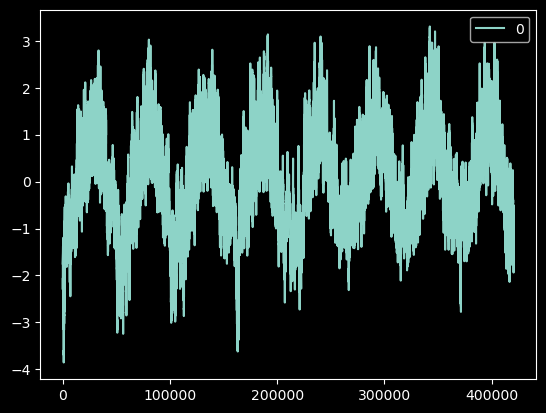

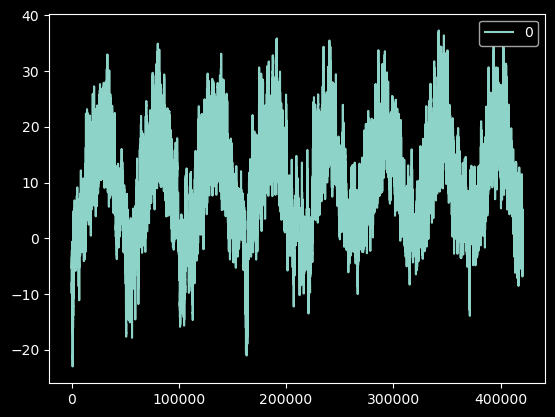

In [57]:
pd.DataFrame(scaled_temps).plot()

pd.DataFrame(hourly_temp).plot()

In [ ]:
# how do we create sequences now ?
X = X.float()
Y = Y.float()

train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [141]:
class TempRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        return self.fc(last)

In [147]:
model = TempRNN()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
x_in = torch.tensor(
    [
        [[4.0], [3.0]],
    ]
)
x_in.shape

print(model.forward(x_in))
x_in[:, -1, :]

tensor([-0.0119], grad_fn=<ViewBackward0>)


tensor([[3.]])

In [148]:
device = torch.device("mps")
model.to(device)
for epoch in range(10):
    model.train()
    for xb, yb in train_loader:

        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)
        # forward pass
        loss.backward()
        # backward pass
        optimizer.step()
        # step
        optimizer.zero_grad()
        # reset the gradients

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()
    print(f"Epoch {epoch}, Val Loss: {val_loss / len(val_loader):.4f}")

/opt/homebrew/Caskroom/mambaforge/base/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([37, 1, 1])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/Caskroom/mambaforge/base/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Val Loss: 69.9995
Epoch 1, Val Loss: 71.5619
Epoch 2, Val Loss: 70.2990
Epoch 3, Val Loss: 71.3024
Epoch 4, Val Loss: 71.5009
Epoch 5, Val Loss: 72.4087
Epoch 6, Val Loss: 71.4335
Epoch 7, Val Loss: 71.2617
Epoch 8, Val Loss: 70.5865
Epoch 9, Val Loss: 70.4851


In [ ]:
print(model.forward(x_in))

tensor([[-0.0562]], grad_fn=<AddmmBackward0>)
